---
title: "Stock Market Trend Forecast"
subtitle: "Using Technical Analysis and Machine Learning"
author: "Hoang Son Lai"
date: "2026-01-23"
categories: [Stock, Technical Analysis, Machine Learning]
format: 
 html:
  toc: true
  css: styles.css
  embed-resources: true
  code-fold: true
---

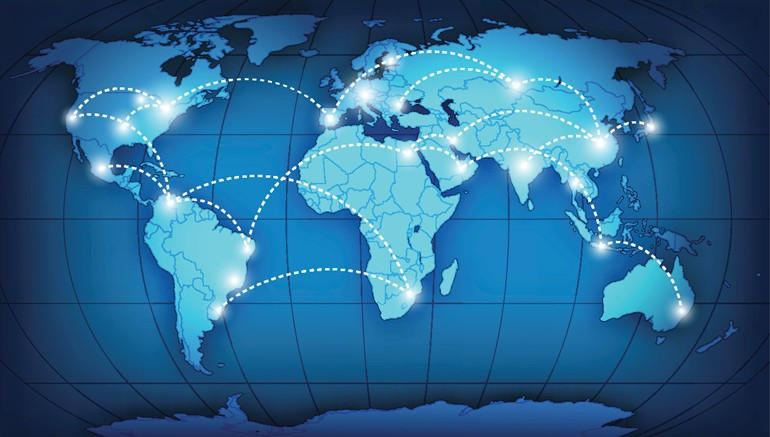

In [45]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"
pio.templates.default = "plotly_white"
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output
# To convert to html use quarto render ml_report.ipynb

# Load Data
try:
    df = pd.read_csv('../../data/cleaned/stock_prices.csv')
    df['date'] = pd.to_datetime(df['date'])
    # Sort by Ticker and Date for accurate calculation
    df = df.sort_values(['ticker', 'date'])
except FileNotFoundError:
    print("Error: File 'stock_prices.csv' not found.")

## Part 1. Technical Analysis

This section provides a comprehensive technical analysis of stock prices using multiple indicators. For each stock, I calculate key metrics: 

1. Trend Indicators:

- MA50/MA200: 50-day and 200-day Simple Moving Averages compare current price to medium/long-term trends (Price > MA = bullish +1, Price < MA = bearish -1)

- EMA20: 20-day Exponential Moving Average gives more weight to recent prices for short-term trend direction

2. Momentum Indicators:

- RSI (14-day): Measures overbought (>70 = -1) vs. oversold (<30 = +1) conditions, with 30-70 being neutral

- MACD: Signal line crossover indicator (MACD > 0 = +1 bullish momentum, MACD < 0 = -1 bearish momentum)

3. Volatility & Volume Indicators:

- Bollinger Bands: Price above upper band = overbought (-1), below lower band = oversold (+1), within bands = neutral (0)

- MFI (Money Flow Index): Volume-weighted RSI (>80 = -1 overbought, <20 = +1 oversold, 20-80 = neutral)

Each indicator is scored (+1 for bullish, -1 for bearish, 0 for neutral), with a final aggregate signal determining the overall market outlook (Positive, Negative, or Neutral).

In [ ]:
# 1. Define a function to calculate indicators for a single dataframe
def calculate_indicators(data):
    # Ensure data is sorted by date
    data = data.sort_values('date').reset_index(drop=True)
    
    # Trend Indicators
    data.ta.sma(length=50, append=True)  # Simple Moving Average (50)
    data.ta.sma(length=200, append=True) # Simple Moving Average (200)
    data.ta.ema(length=20, append=True)  # Exponential Moving Average (20)
    
    # Momentum Indicators
    data.ta.rsi(length=14, append=True)  # Relative Strength Index (14)
    
    # Volatility Indicators - Bollinger Bands
    # Using bbands with standard parameters
    bbands = data.ta.bbands(length=20, std=2, append=True)
    
    # Trend Following (MACD)
    data.ta.macd(fast=12, slow=26, signal=9, append=True)
    
    # Money Flow Index (MFI)
    data.ta.mfi(length=14, append=True)
    
    # Volume
    data['Volume'] = data['volume']
    
    return data

# 2. Apply calculation to all tickers
# Create a list to store processed dataframes
processed_frames = []

# Get list of unique tickers
tickers = df['ticker'].unique()

for ticker in tickers:
    # Filter data for specific ticker
    ticker_df = df[df['ticker'] == ticker].copy()
    
    # Calculate indicators (need at least 200 days for MA200)
    if len(ticker_df) > 200:
        try:
            ticker_df = calculate_indicators(ticker_df)
            processed_frames.append(ticker_df)
            print(f"✓ Processed {ticker}: {len(ticker_df)} rows, columns: {len(ticker_df.columns)}")
        except Exception as e:
            print(f"✗ Error processing {ticker}: {e}")
    else:
        print(f"✗ Skipped {ticker}: Not enough data ({len(ticker_df)} rows, need at least 200)")

# Combine back into a single main DataFrame
if processed_frames:
    df_ta = pd.concat(processed_frames, ignore_index=True)
    print(f"\nCombined DataFrame shape: {df_ta.shape}")
    print(f"Available columns: {df_ta.columns.tolist()}")
else:
    print("No data was processed!")
    df_ta = pd.DataFrame()

# 3. Check column names and find Bollinger Bands columns
if not df_ta.empty:
    print("\nSearching for Bollinger Bands columns...")
    bollinger_cols = [col for col in df_ta.columns if 'BB' in col or 'bb' in col]
    print(f"Bollinger Bands columns found: {bollinger_cols}")
    
    # Find the actual column names for BB upper and lower
    bb_upper = None
    bb_lower = None
    bb_middle = None
    
    for col in bollinger_cols:
        col_lower = col.lower()
        if 'bbu' in col_lower or 'upper' in col_lower:
            bb_upper = col
        elif 'bbl' in col_lower or 'lower' in col_lower:
            bb_lower = col
        elif 'bbm' in col_lower or 'middle' in col_lower:
            bb_middle = col
    
    print(f"Upper BB column: {bb_upper}")
    print(f"Lower BB column: {bb_lower}")
    print(f"Middle BB column: {bb_middle}")

# 4. Calculate scores for each indicator with safe column access
def calculate_scores(row):
    scores = {}
    
    # Helper function to safely get values
    def get_value(col_name, default=np.nan):
        if col_name in row and pd.notna(row[col_name]):
            return row[col_name]
        return default
    
    # MA50 vs Close
    ma50 = get_value('SMA_50')
    if pd.notna(ma50):
        if row['close'] > ma50:
            scores['MA50'] = 1
        elif row['close'] < ma50:
            scores['MA50'] = -1
        else:
            scores['MA50'] = 0
    
    # MA200 vs Close
    ma200 = get_value('SMA_200')
    if pd.notna(ma200):
        if row['close'] > ma200:
            scores['MA200'] = 1
        elif row['close'] < ma200:
            scores['MA200'] = -1
        else:
            scores['MA200'] = 0
    
    # EMA20 vs Close
    ema20 = get_value('EMA_20')
    if pd.notna(ema20):
        if row['close'] > ema20:
            scores['EMA'] = 1
        elif row['close'] < ema20:
            scores['EMA'] = -1
        else:
            scores['EMA'] = 0
    
    # MACD
    macd = get_value('MACD_12_26_9') or get_value('MACD')
    if pd.notna(macd):
        if macd > 0:
            scores['MACD'] = 1
        elif macd < 0:
            scores['MACD'] = -1
        else:
            scores['MACD'] = 0
    
    # RSI
    rsi = get_value('RSI_14')
    if pd.notna(rsi):
        if rsi > 70:
            scores['RSI'] = -1  # Overbought
        elif rsi < 30:
            scores['RSI'] = 1   # Oversold
        else:
            scores['RSI'] = 0   # Neutral
    
    # Bollinger Bands
    if bb_upper and bb_lower:
        bb_upper_val = get_value(bb_upper)
        bb_lower_val = get_value(bb_lower)
        
        if pd.notna(bb_upper_val) and pd.notna(bb_lower_val):
            if row['close'] > bb_upper_val:
                scores['BB'] = -1   # Overbought (above upper band)
            elif row['close'] < bb_lower_val:
                scores['BB'] = 1    # Oversold (below lower band)
            else:
                scores['BB'] = 0    # Within bands
    
    # MFI (Money Flow Index)
    mfi = get_value('MFI_14')
    if pd.notna(mfi):
        if mfi > 80:
            scores['MFI'] = -1  # Overbought
        elif mfi < 20:
            scores['MFI'] = 1   # Oversold
        else:
            scores['MFI'] = 0   # Neutral
    
    # Calculate total score
    total_score = sum(scores.values()) if scores else 0
    
    # Determine signal
    if total_score > 0:
        signal = 'Positive'
    elif total_score < 0:
        signal = 'Negative'
    else:
        signal = 'Neutral'
    
    # Add scores and signal to row
    row['MA50_Score'] = scores.get('MA50', 0)
    row['MA200_Score'] = scores.get('MA200', 0)
    row['EMA_Score'] = scores.get('EMA', 0)
    row['MACD_Score'] = scores.get('MACD', 0)
    row['RSI_Score'] = scores.get('RSI', 0)
    row['BB_Score'] = scores.get('BB', 0)
    row['MFI_Score'] = scores.get('MFI', 0)
    row['Total_Score'] = total_score
    row['Signal'] = signal
    
    return row

# Apply scoring function if we have data
if not df_ta.empty:
    print("\nCalculating scores for each row...")
    df_ta = df_ta.apply(calculate_scores, axis=1)
    
    # 5. Create a summary report table (latest data for each ticker)
    # Get the latest date for each ticker
    latest_dates = df_ta.groupby('ticker')['date'].max()
    
    # Create summary dataframe
    summary_rows = []
    for ticker, latest_date in latest_dates.items():
        ticker_data = df_ta[(df_ta['ticker'] == ticker) & (df_ta['date'] == latest_date)]
        if not ticker_data.empty:
            latest_row = ticker_data.iloc[0]
            
            summary_rows.append({
                'Ticker': ticker,
                'Close Price': latest_row['close'],
                'Volume': latest_row['volume'],
                'MA50': latest_row.get('SMA_50', np.nan),
                'MA200': latest_row.get('SMA_200', np.nan),
                'EMA20': latest_row.get('EMA_20', np.nan),
                'MACD': latest_row.get('MACD_12_26_9', np.nan),
                'RSI': latest_row.get('RSI_14', np.nan),
                'BB Upper': latest_row.get(bb_upper, np.nan) if bb_upper else np.nan,
                'BB Lower': latest_row.get(bb_lower, np.nan) if bb_lower else np.nan,
                'MFI': latest_row.get('MFI_14', np.nan),
                'MA50 Score': latest_row['MA50_Score'],
                'MA200 Score': latest_row['MA200_Score'],
                'EMA Score': latest_row['EMA_Score'],
                'MACD Score': latest_row['MACD_Score'],
                'RSI Score': latest_row['RSI_Score'],
                'BB Score': latest_row['BB_Score'],
                'MFI Score': latest_row['MFI_Score'],
                'Total Score': latest_row['Total_Score'],
                'Signal': latest_row['Signal']
            })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(summary_rows)
    
    # 6. Display the summary table with styling
    def style_scores(val):
        if isinstance(val, (int, float)):
            if val > 0:
                return 'color: green; font-weight: bold;'
            elif val < 0:
                return 'color: red; font-weight: bold;'
            else:
                return 'color: black;'
        return ''
    
    def style_signal(val):
        if val == 'Positive':
            return 'background-color: #d4edda; color: #155724; font-weight: bold;'
        elif val == 'Negative':
            return 'background-color: #f8d7da; color: #721c24; font-weight: bold;'
        else:
            return 'background-color: #fff3cd; color: #856404; font-weight: bold;'
    
    # Apply styling - using map() instead of applymap() for newer pandas versions
    score_columns = ['MA50 Score', 'MA200 Score', 'EMA Score', 'MACD Score', 
                    'RSI Score', 'BB Score', 'MFI Score', 'Total Score']
    
    # Filter columns that actually exist in the dataframe
    existing_score_cols = [col for col in score_columns if col in summary_df.columns]
    
    # Create styler object
    styler = summary_df.style
    
    # Apply formatting
    styler = styler.format({
        'Close Price': '{:.2f}',
        'MA50': '{:.2f}',
        'MA200': '{:.2f}',
        'EMA20': '{:.2f}',
        'MACD': '{:.4f}',
        'RSI': '{:.1f}',
        'BB Upper': '{:.2f}',
        'BB Lower': '{:.2f}',
        'MFI': '{:.1f}',
        'Volume': '{:,.0f}'
    })
    
    # Apply styling to score columns (use map for newer pandas)
    if existing_score_cols:
        styler = styler.map(style_scores, subset=existing_score_cols)
    
    # Apply styling to signal column
    if 'Signal' in summary_df.columns:
        styler = styler.map(style_signal, subset=['Signal'])
    
    # Set properties and table styles
    styler = styler.set_properties(**{
        'text-align': 'center',
        'border': '1px solid #ddd',
        'padding': '5px'
    })
    
    styler = styler.set_caption("Technical Analysis Summary - Latest Signals")



In [47]:
# Display the styled table
styler = (
    styler
    .set_table_attributes('style="width:100%; border-collapse: collapse;"')
    .set_table_styles([
        # table scroll
        {
            "selector": "table",
            "props": [
                ("display", "block"),
                ("overflow-x", "auto"),
                ("white-space", "nowrap")
            ]
        },

        # freeze 1
        {
            "selector": "th:nth-child(1), td:nth-child(1)",
            "props": [
                ("position", "sticky"),
                ("left", "0px"),
                ("background", "white"),
                ("z-index", "3")
            ]
        },

        # freeze 2
        {
            "selector": "th:nth-child(2), td:nth-child(2)",
            "props": [
                ("position", "sticky"),
                ("left", "20px"),   
                ("background", "white"),
                ("z-index", "3")
            ]
        },

        # header
        {
            "selector": "thead th",
            "props": [
                ("background-color", "#4a6fa5"),
                ("color", "white"),
                ("font-weight", "bold"),
                ("padding", "10px"),
                ("border", "1px solid #ddd"),
                ("position", "sticky"),
                ("top", "0"),
                ("z-index", "4")
            ]
        },
        
        {
            "selector": "thead th:nth-child(1), thead th:nth-child(2)",
            "props": [
              ("background-color", "#4a6fa5"),
              ("z-index", "5")
            ]
        },
        
        # body cell
        {
            "selector": "tbody td",
            "props": [
                ("padding", "8px"),
                ("border", "1px solid #ddd")
            ]
        },

        # hover
        {
            "selector": "tr:hover",
            "props": [
                ("background-color", "#f5f5f5")
            ]
        }
    ])
)

display(styler)

,Ticker,Close Price,Volume,MA50,MA200,EMA20,MACD,RSI,BB Upper,BB Lower,MFI,MA50 Score,MA200 Score,EMA Score,MACD Score,RSI Score,BB Score,MFI Score,Total Score,Signal
0,AAPL,269.48,"64,339,600",268.36,237.10,260.64,-1.1592,61.6,270.40,245.02,55.2,1,1,1,-1,0,0,0,2,Positive
1,ADBE,271.93,"8,315,400",326.45,355.64,304.65,-13.0871,23.4,343.72,268.94,42.3,-1,-1,-1,-1,1,0,0,-3,Negative
2,AMZN,238.62,"53,743,900",233.26,222.42,238.58,1.9280,51.2,249.33,231.04,44.2,1,1,1,1,0,0,0,4,Positive
3,BAC,54.45,"41,199,900",53.99,48.90,53.47,-0.3191,56.0,56.96,50.22,58.5,1,1,1,-1,0,0,0,2,Positive
4,DIS,104.22,"24,816,300",109.91,111.48,110.56,-1.0615,34.6,117.58,105.79,41.6,-1,-1,-1,-1,0,1,0,-3,Negative
5,GOOGL,339.71,"36,406,300",320.10,236.09,331.08,6.6895,64.0,345.40,317.51,57.3,1,1,1,1,0,0,0,4,Positive
6,HD,381.10,"5,683,800",359.43,371.62,373.46,5.5974,59.7,395.59,353.90,52.3,1,1,1,1,0,0,0,4,Positive
7,JNJ,233.10,"9,345,400",211.20,178.98,220.59,6.1181,82.3,235.77,201.17,72.2,1,1,1,1,-1,0,0,3,Positive
8,JPM,314.85,"12,685,800",312.85,291.72,309.61,-2.7154,54.5,334.20,288.71,66.5,1,1,1,-1,0,0,0,2,Positive
9,KO,76.89,"27,003,400",71.07,69.28,72.64,1.3824,77.1,76.54,67.21,81.4,1,1,1,1,-1,-1,-1,1,Positive


## Part 2. Machine Learning

### 1. Overview
Building upon the technical analysis in Part 1, this section utilizes **Machine Learning (XGBoost)** to predict stock prices. Unlike traditional indicators that give simple Buy/Sell signals, the ML model analyzes the complex relationships between historical patterns (RSI, MACD, Moving Averages) to forecast the **exact closing price of the next trading day**.

### 2. Methodology
* **Algorithm**: We use **XGBRegressor (Extreme Gradient Boosting)**, a robust algorithm highly effective for structured time-series data.
* **Feature Engineering**: The model inputs include Open, High, Low, Volume, and all technical indicators calculated in Part 1 (SMA, EMA, Bollinger Bands, etc.).
* **Training & Validation**: To prevent "data leakage" (looking into the future), the data is split chronologically:
    * **Training Set (First 80%)**: Used to teach the model historical patterns.
    * **Test Set (Last 20%)**: Used to evaluate how well the model predicts unseen data.

### 3. Interactive Analysis Dashboard
The visualization below provides a comprehensive view of the model's performance. Use the **dropdown menu** to select a specific ticker:
* **Top Chart (Actual vs. Predicted)**: Compares the real market price (Blue line) against the model's prediction (Orange dotted line). The closer the lines, the better the model accuracy.
* **Bottom Chart (Feature Importance)**: Ranks which technical indicators were most influential in determining the price. For example, if *RSI* has a high bar, the model relies heavily on momentum to make predictions for that specific stock.

> **Note**: The table below summarizes the prediction for the **next upcoming trading day**, including the predicted percentage change.

In [48]:
# ==========================================
# Part 2. Machine Learning Prediction
# ==========================================

# 1. Feature Engineering & Data Preparation
# ------------------------------------------
# Identify feature columns (Technical Indicators + Price data)
# We exclude non-numeric columns and the 'Score' columns created in Part 1 logic
exclude_cols = ['ticker', 'date', 'adj_close', 'Signal', 'Volume']
feature_cols = ['open', 'high', 'low', 'close', 'volume']

# Add technical indicator columns created by pandas_ta (usually uppercase)
# We filter out the 'Score' columns we made manually in Part 1
indicator_cols = [c for c in df_ta.columns 
                  if c not in feature_cols + exclude_cols 
                  and 'Score' not in c 
                  and 'Total_Score' not in c]

features = feature_cols + indicator_cols


# Dictionary to store results and models
ml_results = []
ticker_predictions = {}
models = {}


# 2. Training Loop
# ------------------------------------------
for ticker in df_ta['ticker'].unique():
    # Prepare data for this ticker
    df_ticker = df_ta[df_ta['ticker'] == ticker].copy()
    
    # Sort by date ensures time-series integrity
    df_ticker = df_ticker.sort_values('date')
    
    # Create Target: Predict Next Day's Close Price
    # We shift the 'close' price backwards by 1 day
    df_ticker['Target'] = df_ticker['close'].shift(-1)
    
    # Create a cleaner dataset for ML (drop NaNs from indicators and shifting)
    # meaningful_data includes the latest row (which has features but NaN target)
    meaningful_data = df_ticker[features].copy()
    
    # Valid data for training (must have both Features and Target)
    train_data = df_ticker.dropna(subset=features + ['Target'])
    
    if len(train_data) < 100:
        print(f"Skipping {ticker}: Not enough data points ({len(train_data)})")
        continue
        
    # Split Data: Time-Series Split (No random shuffling!)
    # Use first 80% for training, last 20% for testing
    split_idx = int(len(train_data) * 0.8)
    
    X = train_data[features]
    y = train_data['Target']
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train Model (XGBoost)
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    models[ticker] = model
    
    # Evaluate on Test Set
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = np.mean(np.abs(y_test - preds))
    
    # Store test set predictions for visualization
    test_dates = df_ticker.loc[X_test.index, 'date']
    ticker_predictions[ticker] = pd.DataFrame({
        'date': test_dates,
        'Actual': y_test,
        'Predicted': preds
    })
    
    # 3. Future Prediction (Predict Next Day)
    # ------------------------------------------
    # Get the very last row of data (today/latest available)
    last_row = df_ticker.iloc[[-1]][features]
    
    # Predict
    future_pred = model.predict(last_row)[0]
    current_price = df_ticker.iloc[-1]['close']
    predicted_change = ((future_pred - current_price) / current_price) * 100
    
    ml_results.append({
        'Ticker': ticker,
        'Current Date': df_ticker.iloc[-1]['date'],
        'Current Price': current_price,
        'Predicted Next Price': future_pred,
        'Predicted Change %': predicted_change,
        'RMSE (Error)': rmse
    })
    


In [49]:
# 4. Results Summary
# ------------------------------------------
df_ml_results = pd.DataFrame(ml_results)

# Styling the output
def style_ml_results(val):
    if isinstance(val, float):
        if val > 0.5: # Predicted increase > 0.5%
            return 'color: green; font-weight: bold'
        elif val < -0.5: # Predicted decrease > 0.5%
            return 'color: red; font-weight: bold'
    return ''

display(df_ml_results.style.format({
    'Current Price': '{:.2f}',
    'Predicted Next Price': '{:.2f}',
    'Predicted Change %': '{:+.2f}%',
    'RMSE (Error)': '{:.2f}'
}).map(style_ml_results, subset=['Predicted Change %'])
  .set_caption("Machine Learning Price Predictions (Next Trading Day)"))


# 5. Visualization Dashboard
# Create a single Figure with Subplots
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.15,
    subplot_titles=("Price Prediction (Test Set)", "Feature Importance"),
    specs=[[{"type": "scatter"}], [{"type": "bar"}]] # Define types explicitly
)

tickers_list = list(ticker_predictions.keys())
num_tickers = len(tickers_list)

# We will add ALL traces to the figure, but set visible=False for most
# Each ticker adds 3 traces: Actual (Line), Predicted (Line), Importance (Bar)
traces_per_ticker = 3 

for i, ticker in enumerate(tickers_list):
    # Visibility: Only True for the first ticker
    is_visible = (i == 0)
    
    # 1. Actual Price Trace
    pred_df = ticker_predictions[ticker]
    fig.add_trace(
        go.Scatter(
            x=pred_df['date'], 
            y=pred_df['Actual'],
            mode='lines', 
            name=f'Actual',
            line=dict(color='#1f77b4', width=2),
            visible=is_visible,
            legendgroup=f"group_{ticker}"
        ),
        row=1, col=1
    )
    
    # 2. Predicted Price Trace
    fig.add_trace(
        go.Scatter(
            x=pred_df['date'], 
            y=pred_df['Predicted'],
            mode='lines', 
            name=f'Predicted',
            line=dict(color='#ff7f0e', width=2, dash='dot'),
            visible=is_visible,
            legendgroup=f"group_{ticker}"
        ),
        row=1, col=1
    )
    
    # 3. Feature Importance Trace
    model = models[ticker]
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(10)
    
    fig.add_trace(
        go.Bar(
            x=importance['Importance'], 
            y=importance['Feature'],
            orientation='h', 
            name=f'Importance',
            marker_color='#2ca02c',
            visible=is_visible,
            legendgroup=f"group_{ticker}"
        ),
        row=2, col=1
    )

# Create Dropdown Menu Steps
steps = []
for i, ticker in enumerate(tickers_list):
    # Create a visibility array: [False, False, ..., True, True, True, ..., False]
    # Only the 3 traces corresponding to this ticker should be True
    step = dict(
        method="update",
        args=[{"visible": [False] * (num_tickers * traces_per_ticker)},
              {"title": f"Analysis for: {ticker}"}],
        label=ticker
    )
    # Set the 3 traces for this ticker to True
    base_idx = i * traces_per_ticker
    step["args"][0]["visible"][base_idx] = True     # Actual
    step["args"][0]["visible"][base_idx + 1] = True # Predicted
    step["args"][0]["visible"][base_idx + 2] = True # Importance
    
    steps.append(step)

# Add Menu to Layout
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Select Ticker: "},
    pad={"t": 50},
    steps=steps
)]

# Dropdown menu instead of slider for better UI
updatemenus = [dict(
    buttons=steps,
    direction="down",
    pad={"r": 10, "t": 10},
    showactive=True,
    x=0.1,
    xanchor="left",
    y=1.15,
    yanchor="top"
)]

fig.update_layout(
    height=800,
    updatemenus=updatemenus,
    showlegend=True,
    template="plotly_white",
    margin=dict(t=100) # Add margin for dropdown
)

# Explicitly show the figure
fig.show()

,Ticker,Current Date,Current Price,Predicted Next Price,Predicted Change %,RMSE (Error)
0,AAPL,2026-02-03 00:00:00,269.48,242.85,-9.88%,17.36
1,ADBE,2026-02-03 00:00:00,271.93,298.75,+9.86%,9.43
2,AMZN,2026-02-03 00:00:00,238.62,230.69,-3.32%,6.90
3,BAC,2026-02-03 00:00:00,54.45,44.10,-19.01%,6.42
4,DIS,2026-02-03 00:00:00,104.22,101.21,-2.89%,2.72
5,GOOGL,2026-02-03 00:00:00,339.71,190.54,-43.91%,72.66
6,HD,2026-02-03 00:00:00,381.10,377.57,-0.93%,6.66
7,JNJ,2026-02-03 00:00:00,233.10,160.23,-31.26%,28.45
8,JPM,2026-02-03 00:00:00,314.85,257.60,-18.18%,39.66
9,KO,2026-02-03 00:00:00,76.89,68.71,-10.64%,1.80
